In [187]:
import pandas as pd
import os
import glob
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ttest_ind
import itertools
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt


In [188]:
def get_latest_csv(directory):
    list_of_files = glob.glob(os.path.join(directory, '*.csv'))
    if not list_of_files:
        raise FileNotFoundError("No CSV files found in the directory.")
    latest_file = max(list_of_files, key=os.path.getmtime)
    print(f"Using file: {latest_file}")
    return latest_file

In [189]:
latest_csv_path = get_latest_csv("llm_results")
df = pd.read_csv(latest_csv_path)

Using file: llm_results/evaluations_20250505_235141.csv


In [190]:
combine_hyp = pd.read_csv('models_hypotheses/combined_hypotheses.csv')
combine_hyp.rename(columns={'hypo_id': 'hypothesis_id'}, inplace=True)

In [191]:
# Make sure both columns are the same type (e.g., convert both to string or both to int)
df['hypothesis_id'] = df['hypothesis_id'].astype(str)
combine_hyp['hypothesis_id'] = combine_hyp['hypothesis_id'].astype(str)

# Now you can safely join
df = df.join(combine_hyp.set_index('hypothesis_id'), on='hypothesis_id')

In [192]:
df.sort_values(by=['novelty', 'plausibility'], ascending=[False, False], inplace=True)
df.head()


,hypothesis_id,model,novelty,plausibility,timestamp,cancer_type,hypo_factors,Codons,Start_Position,Hugo_Symbol,...,Protein_position,Variant_Type,splice_acceptor_variant,support,method,Unnamed: 0,Consequence,Position,VAR_TYPE_SX,rank
1112,LGBM.NON_SMALL_CELL_LUNG_CANCER.371,openai:o4-mini,9,6,2025-05-05T19:41:00.853349,Non Small Cell Lung Cancer,Site2 Hugo Symbol value is NEK11 AND Smoke Sta...,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,LGBM,NaN,NaN,NaN,NaN,371
2516,XGBS.NON_SMALL_CELL_LUNG_CANCER.166,openai:o4-mini,9,6,2025-05-05T21:50:33.408951,Non Small Cell Lung Cancer,Event Info value is NOTCH2-LIN28A AND Smoke St...,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,XGBS,NaN,NaN,NaN,NaN,166
2915,XGBS.COLORECTAL_CARCINOMA.299,openai:o4-mini,9,5,2025-05-05T22:27:12.564064,Colorectal Carcinoma,TMB (nonsynonymous) value is 2.333333333 AND S...,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,XGBS,NaN,NaN,NaN,NaN,299
3650,XGBS.NON_SMALL_CELL_LUNG_CANCER.544,openai:o4-mini,9,5,2025-05-05T23:32:10.496365,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.133333333 AND E...,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,XGBS,NaN,NaN,NaN,NaN,544
2753,XGBS.BREAST_CARCINOMA.245,openai:o4-mini,9,4,2025-05-05T22:11:06.983067,Breast Carcinoma,Sex value is Female AND Event Info value is PO...,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,XGBS,NaN,NaN,NaN,NaN,245


In [193]:
data = df[df['novelty'] > 6]
data = data[data['plausibility'] > 6]
data = data[(data['novelty'] > 6) | (data['plausibility'] > 6)]
# data['novelty'] = None
# data['plausibility'] = None
data.drop(columns=['timestamp'], inplace=True)

In [194]:
novelty_matrix = df.pivot(index=['hypothesis_id', 'hypo_factors', 'cancer_type'], columns='model', values='novelty')
plausibility_matrix = df.pivot(index='hypothesis_id', columns='model', values='plausibility')

In [195]:
novelty_matrix

,,model,anthropic:claude-3-7-sonnet-latest,openai:o3-mini,openai:o4-mini
hypothesis_id,hypo_factors,cancer_type,,,
LGBM.BREAST_CARCINOMA.112,TMB (nonsynonymous) value is 0.4 AND Diagnosis Age value is 41-50 AND Sex value is Female AND Site1 Hugo Symbol value is BRAF,Breast Carcinoma,3,5,4
LGBM.BREAST_CARCINOMA.155,TMB (nonsynonymous) value is 0.333333333 AND Diagnosis Age value is 41-50 AND Sex value is Female AND Site1 Hugo Symbol value is ATR,Breast Carcinoma,5,3,2
LGBM.BREAST_CARCINOMA.248,TMB (nonsynonymous) value is 0.233333333 AND Sex value is Female AND Site1 Hugo Symbol value is CACNB1,Breast Carcinoma,6,7,7
LGBM.BREAST_CARCINOMA.277,TMB (nonsynonymous) value is 0.2 AND Sex value is Female AND Event Info value is POLR1D-ERBB2 AND Site2 Hugo Symbol value is ERBB2,Breast Carcinoma,6,6,7
LGBM.BREAST_CARCINOMA.318,TMB (nonsynonymous) value is 0.1 AND Diagnosis Age value is 41-50 AND Sex value is Female,Breast Carcinoma,3,2,2
...,...,...,...,...,...
XGBS.SOFT_TISSUE_SARCOMA.617,TMB (nonsynonymous) value is 0.133333333 AND Event Info value is RERE-PIK3CD AND Site1 Hugo Symbol value is RERE AND Site2 Hugo Symbol value is PIK3CD,Soft Tissue Sarcoma,7,7,7
XGBS.SOFT_TISSUE_SARCOMA.618,TMB (nonsynonymous) value is 0.1 AND Diagnosis Age value is 21-30 AND Site2 Hugo Symbol value is FUBP1,Soft Tissue Sarcoma,7,6,8
XGBS.SOFT_TISSUE_SARCOMA.619,TMB (nonsynonymous) value is 0.1 AND Event Info value is FUS-DDIT3 AND Diagnosis Age value is 41-50,Soft Tissue Sarcoma,3,3,2


In [196]:
df.groupby(['hypothesis_id']).agg({
    'novelty': ['mean', 'std'],
    'plausibility': ['mean', 'std']
}).reset_index()

hypothesis_id   novelty           plausibility          
                                        mean       std         mean       std
0        LGBM.BREAST_CARCINOMA.112  4.000000  1.000000     5.000000  2.645751
1        LGBM.BREAST_CARCINOMA.155  3.333333  1.527525     4.333333  2.516611
2        LGBM.BREAST_CARCINOMA.248  6.666667  0.577350     4.000000  2.645751
3        LGBM.BREAST_CARCINOMA.277  6.333333  0.577350     6.000000  2.645751
4        LGBM.BREAST_CARCINOMA.318  2.333333  0.577350     5.333333  2.309401
...                            ...       ...       ...          ...       ...
1289  XGBS.SOFT_TISSUE_SARCOMA.617  7.000000  0.000000     4.000000  1.732051
1290  XGBS.SOFT_TISSUE_SARCOMA.618  7.000000  1.000000     3.333333  2.309401
1291  XGBS.SOFT_TISSUE_SARCOMA.619  2.666667  0.577350     8.333333  0.577350
1292  XGBS.SOFT_TISSUE_SARCOMA.620  7.333333  0.577350     4.000000  1.732051
1293  XGBS.SOFT_TISSUE_SARCOMA.621  8.000000  1.000000     3.666667  2.081666

[1294 rows x 5 columns]

In [197]:
df_pivot = df.pivot(index='hypothesis_id', columns='model', values='novelty')

# Compute standard deviation per sample (variation between models)
df_pivot['std'] = df_pivot.std(axis=1)
df_pivot['range'] = df_pivot.max(axis=1) - df_pivot.min(axis=1)

# Compute pairwise MAE and RMSE between models
def compare_models(col1, col2):
    mae = mean_absolute_error(df_pivot[col1], df_pivot[col2])
    rmse = np.sqrt(mean_squared_error(df_pivot[col1], df_pivot[col2]))
    return mae, rmse

mae_ab, rmse_ab = compare_models('openai:o4-mini', 'anthropic:claude-3-7-sonnet-latest')
mae_ac, rmse_ac = compare_models('openai:o4-mini', 'openai:o3-mini')
mae_bc, rmse_bc = compare_models('anthropic:claude-3-7-sonnet-latest', 'openai:o3-mini')

# Output results

print("Mean Absolute Errors:")
print(f"Model o4-mini vs anthropic: {mae_ab:.2f}")
print(f"Model o4-mini vs o3-mini: {mae_ac:.2f}")
print(f"Model anthropic vs o3-mini: {mae_bc:.2f}")

print("\nRMSE:")
print(f"Model o4-mini vs anthropic: {rmse_ab:.2f}")
print(f"Model o4-mini vs o3-mini: {rmse_ac:.2f}")
print(f"Model anthropic vs o3-mini: {rmse_bc:.2f}")

Mean Absolute Errors:
Model o4-mini vs anthropic: 1.60
Model o4-mini vs o3-mini: 1.42
Model anthropic vs o3-mini: 1.14

RMSE:
Model o4-mini vs anthropic: 2.04
Model o4-mini vs o3-mini: 1.93
Model anthropic vs o3-mini: 1.58


In [198]:
grouped = df.groupby("model")["novelty"].apply(list)

f_stat, p_val = f_oneway(*grouped)
print(f"F-statistic: {f_stat:.4f}, p-value: {p_val:.4e}")

F-statistic: 134.5844, p-value: 3.0866e-57


In [199]:
grouped = df.groupby("model")["plausibility"].apply(list)

f_stat, p_val = f_oneway(*grouped)
print(f"F-statistic: {f_stat:.4f}, p-value: {p_val:.4e}")

F-statistic: 611.8995, p-value: 1.0654e-231


In [200]:
# computing Z score
df[['novelty_norm', 'plausibility_norm']] = df.groupby('model')[['novelty', 'plausibility']].transform(
    lambda x: (x - x.mean()) / x.std()
)

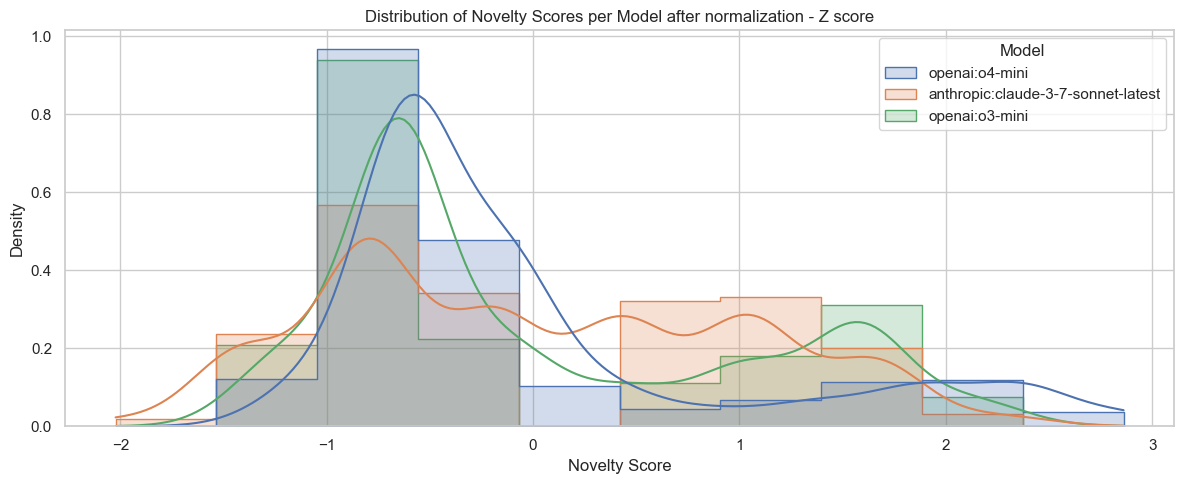

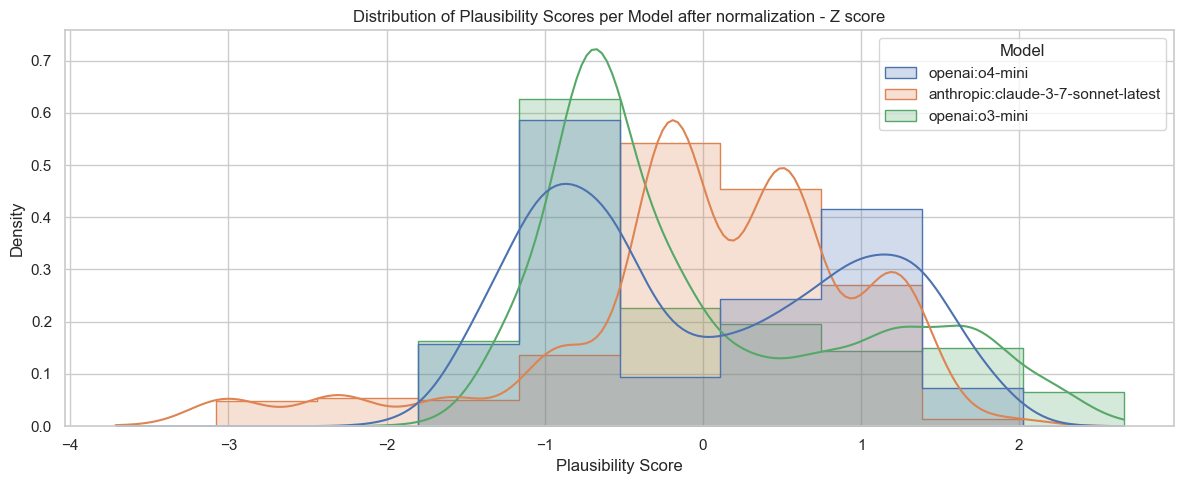

In [201]:
# Ensure 'model' is treated as a categorical variable
# df = merged_df.copy()
df['model'] = df['model'].astype(str)

# Set plot style
sns.set(style="whitegrid")

# Novelty distribution
plt.figure(figsize=(12, 5))
plot1 = sns.histplot(data=df, x="novelty_norm", hue="model", kde=True, bins=10, element="step", stat="density", common_norm=False)
plt.title("Distribution of Novelty Scores per Model after normalization - Z score")
plt.xlabel("Novelty Score")
plt.ylabel("Density")
plot1.legend_.set_title("Model")  # Explicitly set legend title
plt.tight_layout()
plt.show()

# Plausibility distribution
plt.figure(figsize=(12, 5))
plot2 = sns.histplot(data=df, x="plausibility_norm", hue="model", kde=True, bins=10, element="step", stat="density", common_norm=False)
plt.title("Distribution of Plausibility Scores per Model after normalization - Z score")
plt.xlabel("Plausibility Score")
plt.ylabel("Density")
plot2.legend_.set_title("Model")
plt.tight_layout()
plt.show()

In [217]:
# Calculate the 90th percentile thresholds
novelty_thresh = df['novelty_norm'].quantile(0.708)
plausibility_thresh = df['plausibility_norm'].quantile(0.708)

# Filter rows that exceed both thresholds
data = df[(df['novelty_norm'] >= novelty_thresh) & (df['plausibility_norm'] >= plausibility_thresh)]
data

,hypothesis_id,model,novelty,plausibility,timestamp,cancer_type,hypo_factors,Codons,Start_Position,Hugo_Symbol,...,splice_acceptor_variant,support,method,Unnamed: 0,Consequence,Position,VAR_TYPE_SX,rank,novelty_norm,plausibility_norm
782,LGBM.GASTRIC_CANCER.261,openai:o4-mini,8,7,2025-05-05T19:08:40.943703,Gastric Cancer,TMB (nonsynonymous) value is 0.433333333 AND D...,NaN,NaN,NaN,...,NaN,7.0,LGBM,NaN,NaN,NaN,NaN,261,2.366425,0.571540
1949,LIFT.GALLBLADDER_CARCINOMA.17,openai:o4-mini,8,7,2025-05-05T21:01:10.461969,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 5 ...,NaN,NaN,TERT,...,NaN,9.2,LIFT,1426.0,upstream_gene_variant,NaN,Substitution/Indel,17,2.366425,0.571540
411,LGBM.COLORECTAL_CARCINOMA.138,anthropic:claude-3-7-sonnet-latest,7,8,2025-05-05T18:31:22.060548,Colorectal Carcinoma,TMB (nonsynonymous) value is 8.766666667 AND D...,NaN,NaN,NaN,...,NaN,12.0,LGBM,NaN,NaN,NaN,NaN,138,1.658181,0.508440
633,LGBM.NON_SMALL_CELL_LUNG_CANCER.212,anthropic:claude-3-7-sonnet-latest,7,8,2025-05-05T18:52:50.323070,Non Small Cell Lung Cancer,Site2 Hugo Symbol value is LIN28A AND Smoke St...,NaN,NaN,NaN,...,NaN,9.0,LGBM,NaN,NaN,NaN,NaN,212,1.658181,0.508440
780,LGBM.GASTRIC_CANCER.261,anthropic:claude-3-7-sonnet-latest,7,8,2025-05-05T19:08:24.659823,Gastric Cancer,TMB (nonsynonymous) value is 0.433333333 AND D...,NaN,NaN,NaN,...,NaN,7.0,LGBM,NaN,NaN,NaN,NaN,261,1.658181,0.508440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,LGBM.COLORECTAL_CARCINOMA.250,openai:o4-mini,5,7,2025-05-05T19:05:12.489135,Colorectal Carcinoma,Hugo Symbol value is FAT4 AND TMB (nonsynonymo...,NaN,NaN,FAT4,...,NaN,7.0,LGBM,NaN,NaN,NaN,NaN,250,0.880423,0.571540
2387,XGBS.NON_SMALL_CELL_LUNG_CANCER.123,openai:o4-mini,5,7,2025-05-05T21:39:24.835308,Non Small Cell Lung Cancer,Chromosome value is 7 AND Exon Number value is...,NaN,NaN,NaN,...,NaN,12.0,XGBS,NaN,NaN,NaN,NaN,123,0.880423,0.571540
2627,XGBS.BREAST_CARCINOMA.203,openai:o4-mini,5,7,2025-05-05T22:00:24.935266,Breast Carcinoma,Sex value is Female AND Site1 Hugo Symbol valu...,NaN,NaN,NaN,...,NaN,7.0,XGBS,NaN,NaN,NaN,NaN,203,0.880423,0.571540
2923,XGBS.COLORECTAL_CARCINOMA.302,openai:o3-mini,5,7,2025-05-05T22:27:53.124909,Colorectal Carcinoma,Codons value is Cga/Tga AND Hugo Symbol value ...,Cga/Tga,NaN,APC,...,NaN,5.0,XGBS,NaN,NaN,NaN,NaN,302,0.466248,1.223495


In [225]:
data = df[(df["novelty_norm"] > 1) & (df["plausibility_norm"] > 0.5)]
data = data.drop(columns=['timestamp', 'novelty_norm', 'plausibility_norm', 'Unnamed: 0', 'rank'])
data['novelty'] = None
data['plausibility'] = None
data

,hypothesis_id,model,novelty,plausibility,cancer_type,hypo_factors,Codons,Start_Position,Hugo_Symbol,End_Position,...,Smoke Status,Site2_Hugo_Symbol,Protein_position,Variant_Type,splice_acceptor_variant,support,method,Consequence,Position,VAR_TYPE_SX
782,LGBM.GASTRIC_CANCER.261,openai:o4-mini,None,None,Gastric Cancer,TMB (nonsynonymous) value is 0.433333333 AND D...,NaN,NaN,NaN,NaN,...,NaN,NTRK3,NaN,NaN,NaN,7.0,LGBM,NaN,NaN,NaN
1949,LIFT.GALLBLADDER_CARCINOMA.17,openai:o4-mini,None,None,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 5 ...,NaN,NaN,TERT,NaN,...,NaN,NaN,NaN,NaN,NaN,9.2,LIFT,upstream_gene_variant,NaN,Substitution/Indel
411,LGBM.COLORECTAL_CARCINOMA.138,anthropic:claude-3-7-sonnet-latest,None,None,Colorectal Carcinoma,TMB (nonsynonymous) value is 8.766666667 AND D...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.0,LGBM,NaN,NaN,NaN
633,LGBM.NON_SMALL_CELL_LUNG_CANCER.212,anthropic:claude-3-7-sonnet-latest,None,None,Non Small Cell Lung Cancer,Site2 Hugo Symbol value is LIN28A AND Smoke St...,NaN,NaN,NaN,NaN,...,Smoker,LIN28A,NaN,NaN,NaN,9.0,LGBM,NaN,NaN,NaN
780,LGBM.GASTRIC_CANCER.261,anthropic:claude-3-7-sonnet-latest,None,None,Gastric Cancer,TMB (nonsynonymous) value is 0.433333333 AND D...,NaN,NaN,NaN,NaN,...,NaN,NTRK3,NaN,NaN,NaN,7.0,LGBM,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,LGBM.BREAST_CARCINOMA.277,openai:o3-mini,None,None,Breast Carcinoma,TMB (nonsynonymous) value is 0.2 AND Sex value...,NaN,NaN,NaN,NaN,...,NaN,ERBB2,NaN,NaN,NaN,6.0,LGBM,NaN,NaN,NaN
1484,LGBM.COLORECTAL_CARCINOMA.495,openai:o4-mini,None,None,Colorectal Carcinoma,Hugo Symbol value is FAT4 AND TMB (nonsynonymo...,NaN,NaN,FAT4,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,LGBM,NaN,NaN,NaN
1822,LGBM.NON_SMALL_CELL_LUNG_CANCER.608,openai:o3-mini,None,None,Non Small Cell Lung Cancer,Diagnosis Age value is 61-70 AND Site2 Hugo Sy...,NaN,NaN,NaN,NaN,...,Smoker,NEK11,NaN,NaN,NaN,3.0,LGBM,NaN,NaN,NaN
3245,XGBS.LIVER_HEPATOCELLULAR_CARCINOMA.409,openai:o4-mini,None,None,Liver Hepatocellular Carcinoma,Sex value is Male AND Site1 Hugo Symbol value ...,NaN,NaN,NaN,NaN,...,NaN,TERT,NaN,NaN,NaN,4.0,XGBS,NaN,NaN,NaN


In [226]:
data.to_excel("llm_results/normalized_new_results.xlsx", index=False)

In [224]:
data

,hypothesis_id,model,novelty,plausibility,timestamp,cancer_type,hypo_factors,Codons,Start_Position,Hugo_Symbol,...,splice_acceptor_variant,support,method,Unnamed: 0,Consequence,Position,VAR_TYPE_SX,rank,novelty_norm,plausibility_norm
782,LGBM.GASTRIC_CANCER.261,openai:o4-mini,8,7,2025-05-05T19:08:40.943703,Gastric Cancer,TMB (nonsynonymous) value is 0.433333333 AND D...,NaN,NaN,NaN,...,NaN,7.0,LGBM,NaN,NaN,NaN,NaN,261,2.366425,0.571540
1949,LIFT.GALLBLADDER_CARCINOMA.17,openai:o4-mini,8,7,2025-05-05T21:01:10.461969,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 5 ...,NaN,NaN,TERT,...,NaN,9.2,LIFT,1426.0,upstream_gene_variant,NaN,Substitution/Indel,17,2.366425,0.571540
411,LGBM.COLORECTAL_CARCINOMA.138,anthropic:claude-3-7-sonnet-latest,7,8,2025-05-05T18:31:22.060548,Colorectal Carcinoma,TMB (nonsynonymous) value is 8.766666667 AND D...,NaN,NaN,NaN,...,NaN,12.0,LGBM,NaN,NaN,NaN,NaN,138,1.658181,0.508440
633,LGBM.NON_SMALL_CELL_LUNG_CANCER.212,anthropic:claude-3-7-sonnet-latest,7,8,2025-05-05T18:52:50.323070,Non Small Cell Lung Cancer,Site2 Hugo Symbol value is LIN28A AND Smoke St...,NaN,NaN,NaN,...,NaN,9.0,LGBM,NaN,NaN,NaN,NaN,212,1.658181,0.508440
780,LGBM.GASTRIC_CANCER.261,anthropic:claude-3-7-sonnet-latest,7,8,2025-05-05T19:08:24.659823,Gastric Cancer,TMB (nonsynonymous) value is 0.433333333 AND D...,NaN,NaN,NaN,...,NaN,7.0,LGBM,NaN,NaN,NaN,NaN,261,1.658181,0.508440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,LGBM.COLORECTAL_CARCINOMA.250,openai:o4-mini,5,7,2025-05-05T19:05:12.489135,Colorectal Carcinoma,Hugo Symbol value is FAT4 AND TMB (nonsynonymo...,NaN,NaN,FAT4,...,NaN,7.0,LGBM,NaN,NaN,NaN,NaN,250,0.880423,0.571540
2387,XGBS.NON_SMALL_CELL_LUNG_CANCER.123,openai:o4-mini,5,7,2025-05-05T21:39:24.835308,Non Small Cell Lung Cancer,Chromosome value is 7 AND Exon Number value is...,NaN,NaN,NaN,...,NaN,12.0,XGBS,NaN,NaN,NaN,NaN,123,0.880423,0.571540
2627,XGBS.BREAST_CARCINOMA.203,openai:o4-mini,5,7,2025-05-05T22:00:24.935266,Breast Carcinoma,Sex value is Female AND Site1 Hugo Symbol valu...,NaN,NaN,NaN,...,NaN,7.0,XGBS,NaN,NaN,NaN,NaN,203,0.880423,0.571540
2923,XGBS.COLORECTAL_CARCINOMA.302,openai:o3-mini,5,7,2025-05-05T22:27:53.124909,Colorectal Carcinoma,Codons value is Cga/Tga AND Hugo Symbol value ...,Cga/Tga,NaN,APC,...,NaN,5.0,XGBS,NaN,NaN,NaN,NaN,302,0.466248,1.223495


In [205]:
df

,hypothesis_id,model,novelty,plausibility,timestamp,cancer_type,hypo_factors,Codons,Start_Position,Hugo_Symbol,...,splice_acceptor_variant,support,method,Unnamed: 0,Consequence,Position,VAR_TYPE_SX,rank,novelty_norm,plausibility_norm
1112,LGBM.NON_SMALL_CELL_LUNG_CANCER.371,openai:o4-mini,9,6,2025-05-05T19:41:00.853349,Non Small Cell Lung Cancer,Site2 Hugo Symbol value is NEK11 AND Smoke Sta...,NaN,NaN,NaN,...,NaN,5.0,LGBM,NaN,NaN,NaN,NaN,371,2.861759,0.18147
2516,XGBS.NON_SMALL_CELL_LUNG_CANCER.166,openai:o4-mini,9,6,2025-05-05T21:50:33.408951,Non Small Cell Lung Cancer,Event Info value is NOTCH2-LIN28A AND Smoke St...,NaN,NaN,NaN,...,NaN,10.0,XGBS,NaN,NaN,NaN,NaN,166,2.861759,0.18147
2915,XGBS.COLORECTAL_CARCINOMA.299,openai:o4-mini,9,5,2025-05-05T22:27:12.564064,Colorectal Carcinoma,TMB (nonsynonymous) value is 2.333333333 AND S...,NaN,NaN,NaN,...,NaN,5.0,XGBS,NaN,NaN,NaN,NaN,299,2.861759,-0.20860
3650,XGBS.NON_SMALL_CELL_LUNG_CANCER.544,openai:o4-mini,9,5,2025-05-05T23:32:10.496365,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.133333333 AND E...,NaN,NaN,NaN,...,NaN,3.0,XGBS,NaN,NaN,NaN,NaN,544,2.861759,-0.20860
2753,XGBS.BREAST_CARCINOMA.245,openai:o4-mini,9,4,2025-05-05T22:11:06.983067,Breast Carcinoma,Sex value is Female AND Event Info value is PO...,NaN,NaN,NaN,...,NaN,6.0,XGBS,NaN,NaN,NaN,NaN,245,2.861759,-0.59867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874,LGBM.PANCREATIC_CANCER.625,openai:o4-mini,1,3,2025-05-05T20:53:57.519648,Pancreatic Cancer,Protein position value is 12.0 AND TMB (nonsyn...,NaN,NaN,NaN,...,NaN,3.0,LGBM,NaN,NaN,NaN,NaN,625,-1.100912,-0.98874
515,LGBM.COLORECTAL_CARCINOMA.172,openai:o4-mini,1,2,2025-05-05T18:41:21.916446,Colorectal Carcinoma,TMB (nonsynonymous) value is 2.766666667 AND D...,NaN,NaN,NaN,...,NaN,10.0,LGBM,NaN,NaN,NaN,NaN,172,-1.100912,-1.37881
659,LGBM.COLORECTAL_CARCINOMA.220,openai:o4-mini,1,2,2025-05-05T18:55:25.485092,Colorectal Carcinoma,TMB (nonsynonymous) value is 2.933333333 AND D...,NaN,NaN,NaN,...,NaN,8.0,LGBM,NaN,NaN,NaN,NaN,220,-1.100912,-1.37881
3638,XGBS.LIVER_HEPATOCELLULAR_CARCINOMA.540,openai:o4-mini,1,1,2025-05-05T23:31:16.188880,Liver Hepatocellular Carcinoma,Start Position value is 1295228.0 AND End Posi...,NaN,1295228.0,NaN,...,NaN,3.0,XGBS,NaN,NaN,NaN,NaN,540,-1.100912,-1.76888
